## CARGA Y PROCESAMIENTO DE IMÁGENES

In [ ]:
!unzip /content/drive/MyDrive/Datasets/Denoising_Project.zip -d /content

Archive:  /content/drive/MyDrive/Datasets/Denoising_Project.zip
  inflating: /content/Denoising_Project/cap006_10.png  
  inflating: /content/Denoising_Project/cap006_11.png  
  inflating: /content/Denoising_Project/cap006_12.png  
  inflating: /content/Denoising_Project/cap006_14.png  
  inflating: /content/Denoising_Project/cap006_15.png  
  inflating: /content/Denoising_Project/cap006_16.png  
  inflating: /content/Denoising_Project/cap006_17.png  
  inflating: /content/Denoising_Project/cap006_18.png  
  inflating: /content/Denoising_Project/cap006_19.png  
  inflating: /content/Denoising_Project/cap006_20.png  
  inflating: /content/Denoising_Project/cap006_21.png  
  inflating: /content/Denoising_Project/cap006_22.png  
  inflating: /content/Denoising_Project/cap006_23.png  
  inflating: /content/Denoising_Project/cap006_25.png  
  inflating: /content/Denoising_Project/cap006_26.png  
  inflating: /content/Denoising_Project/cap006_27.png  
  inflating: /content/Denoising_Project/

In [ ]:
#Obtengo la ruta donde se encuentra el archivo para obtener las imágenes
path_file="/content/Denoising_Project"

In [ ]:
#Importo las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
import cv2

In [ ]:
#Obtengo, en una lista, los nombres de cada uno de los archivos para cargarlos posteriormente
img_names=os.listdir("/content/Denoising_Project")

In [ ]:
#Creo la función para cargar las imágenes
def cargar_imgs():
  #Aquí almaceno la data
  images=[]

  #Cargo los path para cada imagen
  imgs_path_file=[path_file+"/"+img for img in img_names]

  #Cargo las imágenes en escala de grises
  for img in imgs_path_file:
    img_load=image.load_img(img,target_size=(120,120),color_mode="grayscale")
    img_array=image.img_to_array(img_load)

    #Añado las imágenes
    images.append(img_array)

  return np.array(images)/255

In [ ]:
#Creo la función que se encargará de añadir ruido a las imágenes. En este caso, añadiré ruido 'gaussiano' (mean=0,std=1)
def add_ruido(img,factor_ruido):
  ruido=np.random.normal(loc=0,scale=1,size=(img.shape))
  img_ruido=(img+factor_ruido*ruido).clip(0,1) #Limito los valores en el rango de 0 - 1
  return img_ruido

In [ ]:
#Cargo las imágenes usando la función que creé anteriormente
imgs_arrays=cargar_imgs()

In [ ]:
#Divido las imágenes en train y test, para probar el autoencoder en datos 'nuevos'
from sklearn.model_selection import train_test_split
x_train,x_test=train_test_split(imgs_arrays,test_size=0.08,random_state=42)

In [ ]:
#Genero las imágenes con ruido para la data de train y test
x_train_noised=np.array([add_ruido(img,0.08) for img in x_train]) #0.08 de ruido
x_test_noised=np.array([add_ruido(img,0.08) for img in x_test])

## PLOTTEO DE LAS IMÁGENES ORIGINALES Y SUS CORRESPONDIENTES CON RUIDO AÑADIDO

- La primera fila representan las imágenes originales
- La segunda fila representan las mismas imágenes, pero con ruido añadido

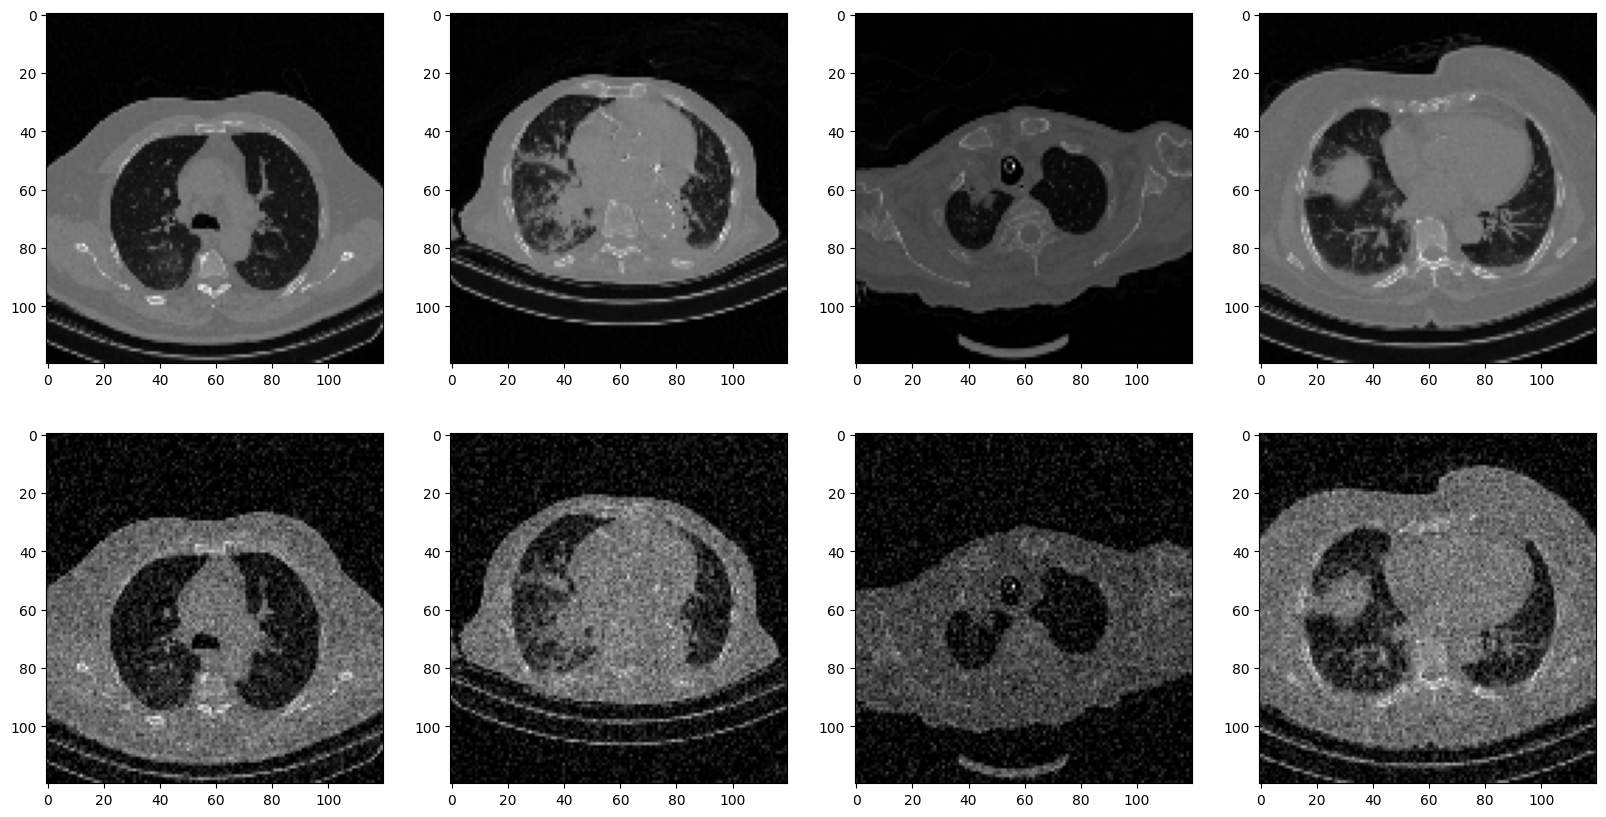

In [ ]:
f, ax = plt.subplots(2, 4)
f.set_size_inches(20,10)
for i in range(4):
    ax[0][i].imshow(np.reshape(x_train[i], (120,120)), aspect='auto', cmap='gray')
    ax[1][i].imshow(np.reshape(x_train_noised[i], (120,120)), aspect='auto', cmap='gray')

## CREACIÓN DE LAS FUNCIONES QUE APLICARÁN LOS FILTROS 'GASSIAN BLUR' Y 'MEDIAN FILTER' A LAS IMÁGENES

In [ ]:
def GaussianBlur(img):
  img_filtrada=cv2.GaussianBlur(img.astype("float32"),(5,5),1) #(5,5),std=1
  return img_filtrada

In [ ]:
def MedianBlur(img):
  img_filtrada=cv2.medianBlur(img.astype("float32"),5) #El promedio del área 5x5 de la imagen
  return img_filtrada

## PLOTTEO ALGUNAS IMÁGENES:
* Fila 1: Imágenes con ruido
* Fila 2: Imágenes donde aplico el kernel GaussianBlur para remover el ruido.
* Fila 3: Imágenes donde aplico el kernel MedianBlur para remover el ruido.

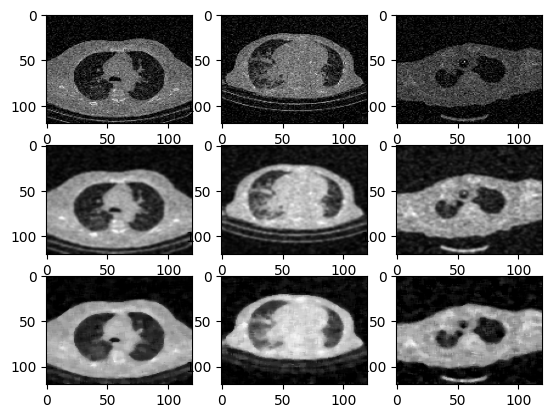

In [ ]:
#Plotteo algunas imágenes
f, ax = plt.subplots(3, 3)
for i in range(3):
    ax[0][i].imshow(np.reshape(x_train_noised[i], (120,120)), aspect='auto', cmap='gray')
    ax[1][i].imshow(np.reshape(GaussianBlur(x_train_noised[i]), (120,120)), aspect='auto', cmap='gray')
    ax[2][i].imshow(np.reshape(MedianBlur(x_train_noised[i]), (120,120)), aspect='auto', cmap='gray')

# CREACIÓN DEL AUTOENCODER

In [ ]:
from keras import layers
import keras

In [ ]:
#Input layer
input_layer=layers.Input(shape=(120,120,1))

In [ ]:
#Creo el encoder
x=layers.Conv2D(16,(3,3),padding="same",activation="relu")(input_layer)
x=layers.MaxPool2D((2,2))(x) #60,60
x=layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=layers.MaxPool2D((2,2))(x) #30,30
x=layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=layers.MaxPool2D((2,2))(x) #15,15

In [ ]:
#Creo el decoder
x=layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=layers.UpSampling2D((2,2))(x) #30,30
x=layers.Conv2D(48,(3,3),padding="same",activation="relu")(x)
x=layers.UpSampling2D((2,2))(x) #60,60
x=layers.Conv2D(20,(32,32),padding="same",activation="relu")(x)
x=layers.UpSampling2D((2,2))(x) #120,120

In [ ]:
decoded_layer=layers.Conv2D(1,(3,3),activation="sigmoid",padding="same")(x) #Uso sigmoid ya que anteriormente rescalé las imágenes de 0-1

In [ ]:
modelo=keras.Model(input_layer,decoded_layer)

In [ ]:
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 60, 60, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 20)     │       983,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 120, 120, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 120, 120, 1)    │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,038,873 (3.96 MB)

 Trainable params: 1,038,873 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

# ENTRENAMIENTO DEL AUTOENCODER

In [ ]:
#Defino el callback early_stopping y model_checkpoint para detener el entrenamiento cuando no haya mejoras y guardar el 'mejor' modelo, respectivamente
from keras.callbacks import EarlyStopping,ModelCheckpoint
ES=EarlyStopping(
    monitor="loss",
    patience=5, #Si la métrica a monitorear no mejora luego de 5 iteraciones del mejor valor para el 'loss', el entrenamiento se detiene
    restore_best_weights=True
)

MC=ModelCheckpoint(
    filepath="/content/modelo.keras",
    monitor="loss",
    save_best_only=True
)

In [ ]:
#Hago el 'compile' del modelo antes de entrenarlo, para especificar qué métricas usará durante el entrenamiento, o el optimizador, etc
modelo.compile(
    optimizer="adam",
    loss="binary_crossentropy" #Pues estoy usando 'sigmoid' function (pues la data está rescalada de 0-1)
)

In [ ]:
history=modelo.fit(
    x_train_noised, #Imágenes con ruido
    x_train, #Imágenes sin ruido que el modelo usará para aprender
    epochs=50,
    callbacks=[ES,MC],
    batch_size=20
)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 57s 333ms/step - loss: 0.4370
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 238ms/step - loss: 0.3707
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - loss: 0.3705
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - loss: 0.3667
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - loss: 0.3586
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - loss: 0.3631
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - loss: 0.3610
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - loss: 0.3607
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - loss: 0.3545
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - loss: 0.3596
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - loss: 0.3564
Epoch 12/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - loss: 0.3565
Epoch 13/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - loss: 0.3564
Epoch 14/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - loss: 0.3585
Epoch 15/50
121

In [ ]:
print(f"Promedio del loss:{np.mean(history.history['loss'])}")

Promedio del loss:0.3570448750257492


# ARQUITECTURA DEL AUTOENCODER

In [ ]:
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 60, 60, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 20)     │       983,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 120, 120, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 120, 120, 1)    │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,116,621 (11.89 MB)

 Trainable params: 1,038,873 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,077,748 (7.93 MB)

# MÉTRICAS DE EVALUACIÓN:

## PSNR

In [ ]:
#Esta función se encarga de evaluar el valor PSNR para la imagen predicha por el autoencoder vs la imagen con ruido correspondientes
def PSNR(img_eval,img_orig,max_value=1):
  mse=np.mean((img_eval-img_orig)**2)
  psnr=10*np.log10((max_value)**2/mse)
  return psnr

## SSIM

In [ ]:
#Import el algoritmo de skimage
from skimage.metrics import structural_similarity as ssim
def SSIM(img_eval,img_orig):
  ssim_score= ssim(np.squeeze(img_eval),np.squeeze(img_orig), data_range=1)
  return ssim_score

# EVALUACIÓN
- Notar que un valor más alto de PSNR significa que la reconstrucción de la imagen es más 'idéntica' a la imagen original, ya que implica un MSE menor (es decir, el error es menos).
- Mientras más cerca el valor de SSIM esté de 1, significa que la reconstrucción de la imagen es más parecida a la imagen original.

### USANDO EL AUTOENCODER:

In [ ]:
#Aquí uso el modelo autoencoder en las imágenes de test para la evaluación
x_test_ae=modelo.predict(x_test_noised)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 770ms/step


#### PSNR: IMÁGENES REALES | IMÁGENES DEL AUTOENCODER

In [ ]:
#Valor medio de PSNR del autoencoder en las imágenes de test
mean_psnr_ae=[]
for i in range(x_test.shape[0]):
  mean_psnr_ae.append(PSNR(x_test[i],x_test_ae[i]))
print(f"Media de la métrica PSNR en las imágenes de test: {np.mean(np.array(mean_psnr_ae))}")

Media de la métrica PSNR en las imágenes de test: 27.053668975830078


#### SSIM: IMÁGENES REALES | IMÁGENES DEL AUTOENCODER

In [ ]:
#Valor medio de SSIM del autoencoder en las imágenes de test
mean_ssim_ae=[]
for i in range(x_test.shape[0]):
  mean_ssim_ae.append(SSIM(x_test[i],x_test_ae[i]))
print(f"Media de la métrica PSNR en las imágenes de test: {np.mean(np.array(mean_ssim_ae))}")

Media de la métrica PSNR en las imágenes de test: 0.7886712573222626


----

### USANDO MEDIAN BLUR:

#### PSNR: IMÁGENES REALES | IMÁGENES APLICANDO MEDIAN BLUR

In [ ]:
#Valor medio de median blur con la métrica PSNR en las imágenes de test
psnr_m_blur=[]
for i in range(x_test.shape[0]):
  psnr_m_blur.append(PSNR(x_test[i],MedianBlur(x_test_noised[i])))
print(f"Media de la métrica PSNR en las imágenes de test: {np.mean(np.array(psnr_m_blur))}")

Media de la métrica PSNR en las imágenes de test: 12.511493682861328


#### SSIM: IMÁGENES REALES | IMÁGENES APLICANDO MEDIAN BLUR

In [ ]:
#Valor medio de median blur con la métrica SSIM en las imágenes de test
ssim_m_blur=[]
for i in range(x_test.shape[0]):
  ssim_m_blur.append(SSIM(x_test[i],MedianBlur(x_test_noised[i])))
print(f"Media de la métrica PSNR en las imágenes de test: {np.mean(np.array(ssim_m_blur))}")

Media de la métrica PSNR en las imágenes de test: 0.6465682907408488


-----

### USANDO GAUSSIAN BLUR:

#### PSNR: IMÁGENES REALES | IMÁGENES APLICANDO GAUSSIAN BLUR

In [ ]:
#Valor medio de gaussian blur con la métrica PSNR en las imágenes de test
psnr_g_blur=[]
for i in range(x_test.shape[0]):
  psnr_g_blur.append(PSNR(x_test[i],GaussianBlur(x_test_noised[i])))
print(f"Media de la métrica PSNR en las imágenes de test: {np.mean(np.array(psnr_g_blur))}")

Media de la métrica PSNR en las imágenes de test: 12.655463218688965


#### SSIM: IMÁGENES REALES | IMÁGENES APLICANDO MEDIAN BLUR

In [ ]:
#Valor medio de gaussian blur con la métrica SSIM en las imágenes de test
ssim_g_blur=[]
for i in range(x_test.shape[0]):
  ssim_g_blur.append(SSIM(x_test[i],GaussianBlur(x_test_noised[i])))
print(f"Media de la métrica PSNR en las imágenes de test: {np.mean(np.array(ssim_g_blur))}")

Media de la métrica PSNR en las imágenes de test: 0.6412973922621209


----

# RESULTADOS BASADOS EN LOS VALORES DE LAS MÉTRICAS
* La media obtenida de la métrica PSNR y SSIM para todas las imágenes de test,  cuyo valor fue el mejor, se obtuvo de las denoised images generadas por el autoencoder.
* Se puede ver claramente que la media evaluada en las imágenes de test con la métrica SSIM es un 15% mejor que las denoised images a las que se les aplicó los approaches tradicionales (gaussian blur y median blur); mientras que la métrica PSNR tuvo el doble de valor en las denoised images generadas por el autoencoder que al usar los enfoques tradicionales.

----

# RESULTADOS VISUALES:
* Fila 1: Imágenes con ruido
* Fila 2: Imágenes sin ruido
* Fila 3: Imágenes donde aplico el autoencoder para remover el ruido
* Fila 4: Imágenes donde aplico el kernel GaussianBlur para remover el ruido
* Fila 5: Imágenes donde aplico el kernel MedianBlur para remover el ruido

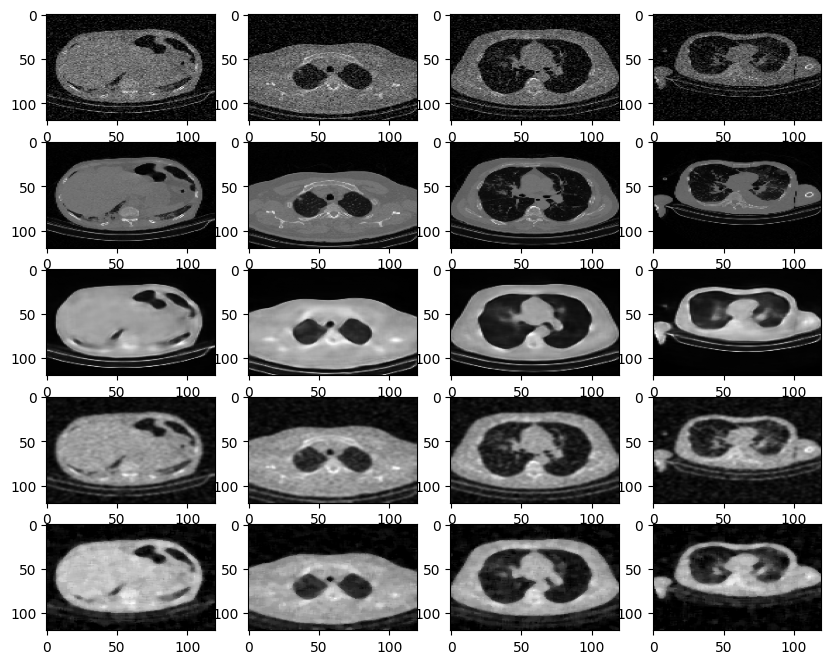

In [ ]:
#Plotteo algunas imágenes
f1, ax1 = plt.subplots(5, 4)
f1.set_size_inches(10,8)
for i in range(4):
    ax1[0][i].imshow(np.reshape(x_test_noised[i], (120,120)), aspect='auto', cmap='gray')
    ax1[1][i].imshow(np.reshape(x_test[i], (120,120)), aspect='auto', cmap='gray')
    ax1[2][i].imshow(np.reshape(x_test_ae[i], (120,120)), aspect='auto', cmap='gray')
    ax1[3][i].imshow(np.reshape(GaussianBlur(x_test_noised[i]), (120,120)), aspect='auto', cmap='gray')
    ax1[4][i].imshow(np.reshape(MedianBlur(x_test_noised[i]), (120,120)), aspect='auto', cmap='gray')